In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import random_split, DataLoader

# Loading Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Pre-Processing(designed transformations to be used in the next cell)

Resized the image to 224x224 size as expected by VGGs

Used normalization, data augmentation using pre-defined transformations in the pytorch module

In [3]:


#Used normalization base on the ImageNet inputs as VGG expects
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# For training set
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

# For validation and test
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])


In [4]:
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

# Splitted training dataset(50,000 images) into 45,000 and 5,000 for training and validation

train_size = int(0.9 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

# Apply different transform for valset (override)
valset.dataset.transform = test_transform

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Dataloaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader   = DataLoader(valset, batch_size=64, shuffle=False)
testloader  = DataLoader(testset, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:03<00:00, 43.5MB/s]


In [5]:
vgg16 = models.vgg16(pretrained=True)

# Freeze convolutional layers
for param in vgg16.features.parameters():
    param.requires_grad = False

# Replacing the last layer of classifier from (4096 -> 1000) to (4096 -> 10) to suit our requirements
vgg16.classifier[6] = nn.Linear(4096, 10)
vgg16 = vgg16.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 73.0MB/s]


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=1e-4)


In [7]:
for epoch in range(10):
    vgg16.train()
    train_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation loop
    vgg16.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(trainloader):.4f} | "
          f"Val Loss: {val_loss/len(valloader):.4f} | "
          f"Val Acc: {100 * val_correct / val_total:.2f}%")


Epoch 1 | Train Loss: 0.4966 | Val Loss: 0.3706 | Val Acc: 86.62%
Epoch 2 | Train Loss: 0.2159 | Val Loss: 0.3587 | Val Acc: 88.02%
Epoch 3 | Train Loss: 0.0959 | Val Loss: 0.3991 | Val Acc: 88.14%
Epoch 4 | Train Loss: 0.0517 | Val Loss: 0.4602 | Val Acc: 88.32%
Epoch 5 | Train Loss: 0.0451 | Val Loss: 0.5232 | Val Acc: 87.94%
Epoch 6 | Train Loss: 0.0375 | Val Loss: 0.5338 | Val Acc: 88.52%
Epoch 7 | Train Loss: 0.0336 | Val Loss: 0.5583 | Val Acc: 88.44%
Epoch 8 | Train Loss: 0.0331 | Val Loss: 0.5819 | Val Acc: 88.54%
Epoch 9 | Train Loss: 0.0344 | Val Loss: 0.5984 | Val Acc: 88.32%
Epoch 10 | Train Loss: 0.0258 | Val Loss: 0.6556 | Val Acc: 88.52%


In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize


def _save_and_show(fig, path):
    """Save the figure then immediately show it."""
    fig.tight_layout()
    fig.savefig(path, dpi=300)
    plt.show()
    plt.close(fig)


# 1️⃣ Confusion-matrix plot
def plot_confusion_matrix(y_true, y_pred, class_names, save_path):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(cm, cmap="Blues")

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix")

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, cm[i, j], ha="center", va="center")

    fig.colorbar(im)
    _save_and_show(fig, save_path)


# 2️⃣ ROC-AUC curves (One-vs-All)
def plot_roc_curves(y_true, y_prob, class_names, save_path):
    y_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
    fig, ax = plt.subplots()
    aucs = []

    for i, name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
        auc = roc_auc_score(y_bin[:, i], y_prob[:, i])
        aucs.append(auc)
        ax.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curves (OvA)")
    ax.legend(loc="lower right")

    _save_and_show(fig, save_path)
    return np.mean(aucs)


# 3️⃣ Precision-Recall curves (optional)
def plot_precision_recall(y_true, y_prob, class_names, save_path):
    y_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
    fig, ax = plt.subplots()
    aps = []

    for i, name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(y_bin[:, i], y_prob[:, i])
        ap = average_precision_score(y_bin[:, i], y_prob[:, i])
        aps.append(ap)
        ax.plot(recall, precision, label=f"{name} (AP={ap:.2f})")

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision–Recall Curves")
    ax.legend(loc="upper right")

    _save_and_show(fig, save_path)
    return np.mean(aps)


Evaluating: 100%|██████████| 157/157 [01:06<00:00,  2.36it/s]



✅ Accuracy:  0.8832
✅ Precision: 0.8842
✅ Recall:    0.8832
✅ F1 Score:  0.8832


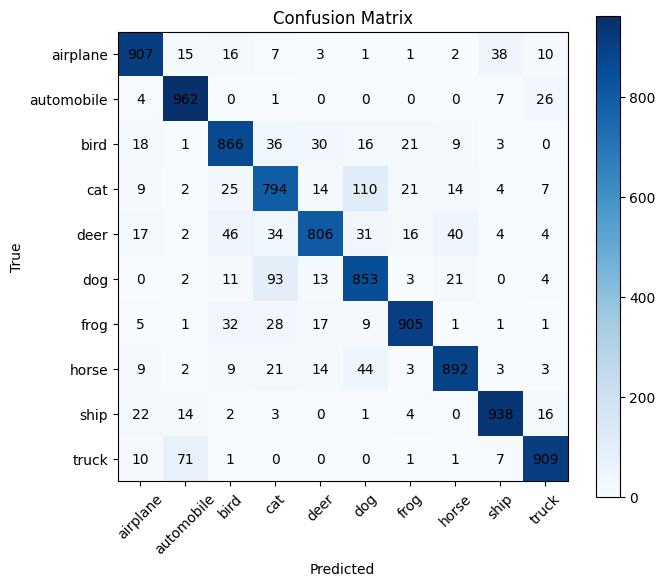

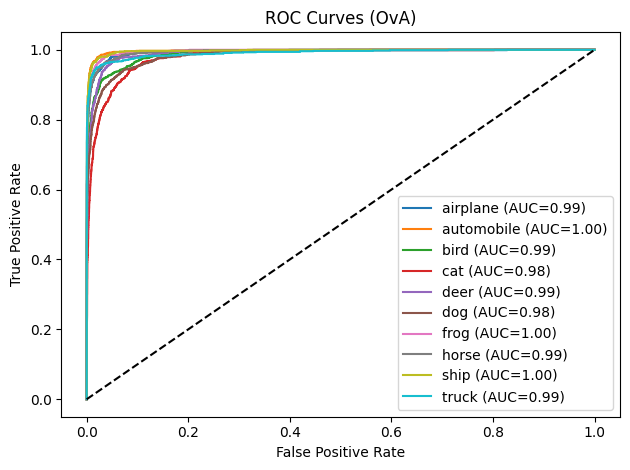

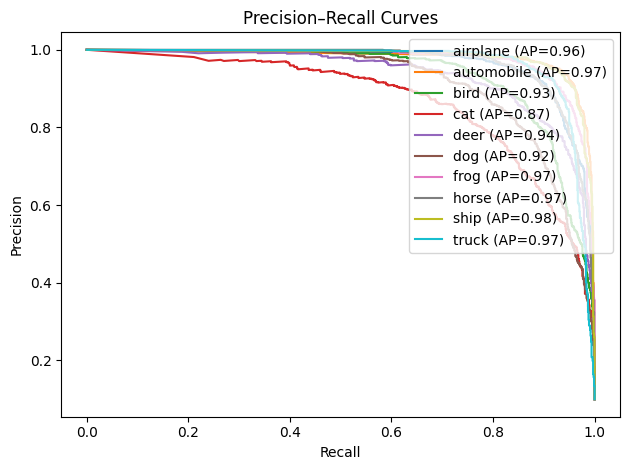


📊 Evaluation plots saved in: /content/vgg16_eval_outputs

📊 Final metrics: {'accuracy': 0.8832, 'precision': 0.8842119835560645, 'recall': 0.8832000000000001, 'f1': 0.8832197206681714, 'roc_auc_macro': np.float64(0.9913364111111111), 'pr_auc_macro': np.float64(0.9479094747422222)}


In [17]:
# After training your model …

results = evaluate_model(
    model=vgg16,
    dataloader=testloader,
    device=device,
    class_names=[
        "airplane","automobile","bird","cat","deer",
        "dog","frog","horse","ship","truck"
    ],
    save_dir="vgg16_eval_outputs",   # figures stored here
    plot_pr_curve=True               # enables PR curves
)

print("\n📊 Final metrics:", results)
